## Beta Bank

## 1. Contenido

* [1 Contenido](#content)
* [2 Introducción](#intro)
* [3 Inicialización](#inic)
    * [3.1 Cargar Librerias](#library)
    * [3.2 Cargar Datos](#datos)
* [4 Exploración de los datos](#exp)
    * [4.1 Completar valores ausentes](#ausentes)      
* [5 Segmentación de los datos](#segmentacion) 
* [6 Equilibrio de clases](#equilibrio)
    * [6.1 Matriz de confusión](#matriz)    
* [7 Calidad y elección del modelo](#calidad)
    * [7.1 Elección del modelo](#modelo)
        * [7.1.1 Árbol de desición](#arbol)
        * [7.2.1 Bosque aleatorio](#bosque)
        * [7.3.1 Regresión logística](#regresion)
    * [7.2 Desequilibrio de clases](#desequilibrio)
        * [7.2.1 Ajuste peso de clase](#ajuste)
        * [7.2.2 Submuestreo](#sub)
        * [7.2.3 Sobremuestreo](#sob)
    * [7.2 Conclusión modelos](#end_m)        
* [8 Prueba final](#final)    
* [9 Conclusiones](#end)

## 2. Introducción

En el presente proyecto Beta Bank nos ha solicitado desarrollar un modelo para predecir si sus clientes dejarán el banco a corto plazo. Beta Bank nos ha proporcionado un dataset con los datos sobre el comportamiento de clientes pasados e información sobre la terminación de sus contratos.

Comenzaremos revisando el dataset proporcionado, examinaremos el equilibrio de clases existente en el dataset, comprobaremos distintos modelos y mejoraremos su calidad a través del ajuste de parámetros para encontrar el más óptimo para el proyecto.

## 3. Inicialización

### 3.1 Cargar librerias

Se procede a cargar las librerías que se utilizaran en el proyecto.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np

### 3.2 Cargar datos

Se procede a cargar los datos.

In [2]:
bank = pd.read_csv('datasets/Churn.csv')

## 4. Exploración de los datos

A continuación, procederemos a realizar un análisis sobre los datos entregados por Beta Bank.

In [3]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
bank.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


En primera instancia podemos observar datos ausentes en la columna "Tenure", estas filas deberán ser rellenadas o eliminadas ya que los modelos utilizados no aceptan valores ausentes dentro de los datos. Continuaremos revisando la existencia de filas duplicadas o datos extraños dentro de los datos para posteriormente abordar la columna "Tenure".

In [5]:
bank['CustomerId'].duplicated().sum()

0

Observando la cantidad de valores duplicados en la columna "CustomerID" que funciona como identificador único de cada cliente podemos concluir que no existen filas duplicadas.

In [6]:
for column in bank[['CreditScore', 'Balance', 'EstimatedSalary', 'NumOfProducts']]:
    print(f'{column}: {(bank[bank[column] >= 0][column]).count()}')

CreditScore: 10000
Balance: 10000
EstimatedSalary: 10000
NumOfProducts: 10000


No se aprecian valores negativos extraños en las columnas.

In [7]:
bank['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

Se observa que los clientes de Beta Bank pertenecen a los paises de Francia, España o Alemania.

In [8]:
bank.loc[(bank['Age'] >= 18) & (bank['Age'] <= 92), ['Age']].count()

Age    10000
dtype: int64

El valor de edad de todos los clientes se encuentra entre la mayoría de edad y los 92 años.

In [9]:
for column in bank[['HasCrCard', 'IsActiveMember', 'Exited']]:
    print(f'{column}: {bank[column].unique()}')

HasCrCard: [1 0]
IsActiveMember: [1 0]
Exited: [1 0]


Las columnas "HasCrCard", "IsActiveMember" y "Exited" solo poseen valores de carácter booleano como deber ser para columnas que representan si los clientes han hecho o no algo.

### 4.1 Completar valores ausentes

Se procederá a analizar la columna "Tenure".

In [10]:
bank['Tenure'].value_counts(normalize=True).head(10)

1.0     0.104719
2.0     0.104499
8.0     0.102629
3.0     0.102079
5.0     0.101969
7.0     0.101749
4.0     0.097349
9.0     0.097019
6.0     0.096909
10.0    0.049060
Name: Tenure, dtype: float64

Podemos observar la distribución de valores de la columna “Tenure” para un posterior análisis de cómo afecta el llenado de datos que realizaremos. Por otra parte, apreciamos que la distribución para el periodo de maduración de los depósitos de los clientes es más o menos parejos para todos los años presentes en los datos exceptuando el plazo de 10 años. Debido a que los valores de años son números enteros utilizaremos la moda para completar los datos para que no se completen los datos con valores decimales por utilizar la mediana o la media.

Con respecto a sobre que columna iterar los datos se decidió utilizar el salario estimado de cada cliente bajo la hipótesis de que la cantidad de años de maduración que solicita el cliente para sus depósitos fijos está relacionado con el salario del mismo debido a que un mayor salario puede permitir a la persona tener ese dinero “retenido” por una mayor cantidad de años.

Procederemos creando una nueva columna para agrupar los salarios en rangos, posteriormente rellenaremos los valores ausentes en función de la moda de estos rangos, finalmente compararemos como ha variado la distribución de valores de la columna "Tenure".

In [11]:
def salary_group(salary):
    if 0 <= salary < 25000:
        return "0-24999"
    elif 25000 <= salary < 50000:
        return "25000-49999"
    elif 50000 <= salary < 75000:
        return "50000-74999"
    elif 75000 <= salary < 100000:
        return "75000-99999"
    elif 100000 <= salary < 125000:
        return "100000-124999"
    elif 125000 <= salary < 150000:
        return "125000-149999"
    elif 150000 <= salary < 175000:
        return "150000-174999"
    elif 175000 <= salary <= 200000:
        return "175000-200000"

In [12]:
bank["salary_group"] = bank["EstimatedSalary"].apply(salary_group)

In [13]:
tenure_not_null = bank.dropna()

In [14]:
tenure_mode = tenure_not_null.pivot_table(index=["salary_group"], values="Tenure", 
                                                aggfunc = lambda x: x.mode().iloc[0])
tenure_mode

,Tenure
salary_group,
0-24999,1.0
100000-124999,1.0
125000-149999,8.0
150000-174999,5.0
175000-200000,8.0
25000-49999,3.0
50000-74999,3.0
75000-99999,5.0


In [15]:
def llenar(carac, moda):
    bank.loc[(bank["salary_group"]==carac), "Tenure"
             ] = bank.loc[(bank["salary_group"]==carac)]["Tenure"].fillna(moda)

In [16]:
df_tenure_mode = tenure_mode.reset_index()
df_tenure_mode.apply(lambda x: llenar(x["salary_group"], x["Tenure"]), axis=1)

0    None
1    None
2    None
3    None
4    None
5    None
6    None
7    None
dtype: object

In [17]:
bank["Tenure"].isna().sum()

0

In [18]:
bank['Tenure'].value_counts(normalize=True).head(10)

3.0     0.1181
1.0     0.1176
8.0     0.1155
5.0     0.1137
2.0     0.0950
7.0     0.0925
4.0     0.0885
9.0     0.0882
6.0     0.0881
10.0    0.0446
Name: Tenure, dtype: float64

Se puede observar que ha existido una variación en la distribución de valores de la columna "Tenure" pero la máxima variación ha sido de alrededor de un 1,5% lo cual es un valor aceptable.

In [19]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
 14  salary_group     10000 non-null  object 
dtypes: float64(3), int64(8), object(4)
memory usage: 1.1+ MB


## 5. Segmentación de los datos

Continuaremos con la segmentación de los datos, comenzaremos utilizando una codificación de etiquetas para las columnas debido a que utilizaremos modelos basados en árboles.

In [20]:
encoder = OrdinalEncoder()
bank_ordinal = pd.DataFrame(encoder.fit_transform(bank), columns=bank.columns)

Continuamos dividiendo el dataframe en dos, uno con las columnas "características" y otro con la columna "objetivo". En el caso del dataframe "características" eliminamos la columna "objetivo" y las columnas que no son de interés para el entrenamiento de nuestro modelo.

In [21]:
features = bank_ordinal.drop(['Exited', 'RowNumber', 'CustomerId', 'Surname', 'salary_group'], axis=1)
target = bank_ordinal['Exited']

Ahora procederemos a realizar la segmentación de los datos en tres conjuntos, uno de entrenamiento, uno de validación y uno de prueba. Para llevarlo a cabo utilizaremos la función "train_test_split" la cual separa nuestro dataframe en dos, como necesitamos tres conjuntos realizaremos este proceso dos veces para conseguir los conjuntos anteriormente mencionados en una proporción de 3:1:1.

In [22]:
features_train1, features_valid, target_train1, target_valid = train_test_split(
    features, target, test_size=0.2, random_state=12345)

In [23]:
features_train, features_test, target_train, target_test = train_test_split(
    features_train1, target_train1, test_size=0.25, random_state=12345)

In [24]:
for data in [features_train, features_valid, features_test]:
    print(f'{len(data)/len(features)}')

0.6
0.2
0.2


Podemos observar que los dataframes obtenido de entrenamiento, validación y prueba se encuentran en la proporción 3:1:1 definida.

## 6. Equilibrio de clases

Procederemos a examinar el equilibro de clases existente en los datos, para esto utilizaremos un modelo de prueba sin mayores ajustes.

In [25]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train, target_train) 
predictions = model.predict(features_valid) 
result = accuracy_score(target_valid, predictions)
result

0.7865

In [26]:
target_pred_constant = pd.Series(target.replace({1 : 0}))
print(accuracy_score(target, target_pred_constant)) 

0.7963


Podemos apreciar un claro desequilibrio de clases en los datos entregados, al comprobar la exactitud de un modelo con un valor constante de 0 en la columna "Exited" representando que todos los clientes se mantienen en el banco la tasa de exactitud del modelo es de 0.79, un valor muy alto para un modelo de predicción constante y a su vez teniendo una exactitud mayor que el modelo entrenado de prueba.

### 6.1 Matriz de confusion

In [27]:
print(confusion_matrix(target_valid,predictions))

[[1362  211]
 [ 216  211]]


Al observar la matriz de confusión del modelo entrenado podemos apreciar que la mayoría de los resultados son verdaderos negativos, encontrándose estos en una proporción 7 veces mayor con respecto al resto de los resultados. Lo anterior corrobora el resultado obtenido anteriormente de que los datos presentan un claro desequilibrio de clases en favor de los valores de 0 en la columna "Tenure".

## 7. Elección y ajuste de modelo

### 7.1 Elección del modelo

Comenzaremos con una comparación entre distintos algoritmos de aprendizaje realizando a su vez el ajuste de sus hiperparámetros para obtener el mejor resultado posible, así elegiremos el modelo que presente un mayor valor f1.

#### 7.1.1. Árbol de desición

In [28]:
best_model = None
best_result = 0
best_leaf = 0
best_depth = 0
bs_split = 0
for leaf in range(1, 10):
    for depth in range (1, 10):
        for split in range(2,10):
            model = DecisionTreeClassifier(random_state=12345, min_samples_leaf=leaf,  max_depth=depth, min_samples_split=split)
            model.fit(features_train, target_train) 
            predictions = model.predict(features_valid) 
            result = f1_score(target_valid, predictions)
            if result > best_result:
                best_model = model
                best_result = result
                best_leaf = leaf
                best_depth = depth
                best_split = split
print("mejor modelo para mayor F1", best_result, "min_leaf:", best_leaf, "best_depth:", best_depth, "best_split:", best_split)

mejor modelo para mayor F1 0.5535714285714285 min_leaf: 8 best_depth: 7 best_split: 2


#### 7.1.2. Bosque aleatorio

In [29]:
best_model = None
best_result = 0
best_est = 0
best_depth = 0
best_split = 0
for est in range(10, 101, 10):
    for depth in range (1, 11):
        for split in range(2,8):
            model = RandomForestClassifier(random_state=12345, n_estimators=est,  max_depth=depth, min_samples_split=split)
            model.fit(features_train, target_train) 
            predictions = model.predict(features_valid) 
            result = f1_score(target_valid, predictions)
            if result > best_result:
                best_model = model
                best_result = result
                best_est = est
                best_depth = depth
                best_split = split
print("mejor modelo para mayor F1", best_result, "n_estimators:", best_est, "best_depth:", best_depth, "best_min_sample_split:", best_split)

mejor modelo para mayor F1 0.5485362095531587 n_estimators: 80 best_depth: 10 best_min_sample_split: 3


#### 7.1.3. Regresión logistica

In [30]:
best_model = None
best_result = 0
best_solv = None
best_penal = None
for solv in ('liblinear', 'saga'):
    for penal in ('l1','l2'):
        model = LogisticRegression(random_state=12345, solver=solv, penalty=penal)
        model.fit(features_train, target_train) 
        predictions = model.predict(features_valid) 
        result = accuracy_score(target_valid, predictions)
        if result > best_result:
                    best_model = model
                    best_result = result
                    best_solv = solv
                    best_penal = penal
print("mejor modelo en el conjunto de validación", best_result, "solver:", best_solv, "penal:", best_penal)

mejor modelo en el conjunto de validación 0.7955 solver: liblinear penal: l1


C:\Users\digom\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\digom\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [31]:
model = LogisticRegression(random_state=12345, solver='liblinear', penalty='l1')
model.fit(features_train, target_train) 
predictions = model.predict(features_valid) 
print('F1:', f1_score(target_valid, predictions))

F1: 0.24118738404452691


Observando los resultados obtenidos con cada modelo, continuaremos el proyecto evaluando tanto el árbol de decisión como el bosque aleatorio con los hiperparámetros definidos ya que la diferencia en el F1 obtenida es muy estrecha.

### 7.2 Desequilibrio de clases

Continuaremos haciendo uso del modelo anteriormente escogido y afrontando el desequilibrio de clases haciendo uso de diversos enfoques con el objetivo de maximizar f1 lo más posible.

#### 7.2.1. Ajuste peso de clase

In [32]:
model = DecisionTreeClassifier(random_state=12345, min_samples_leaf=8,  max_depth=7,  min_samples_split=2, class_weight='balanced')
model.fit(features_train, target_train)
predictions = model.predict(features_valid) 
print('F1:', f1_score(target_valid, predictions))

F1: 0.582089552238806


In [65]:
model =RandomForestClassifier(random_state=12345, n_estimators=80,  max_depth=10, min_samples_split=2, class_weight='balanced')
model.fit(features_train, target_train)
predictions = model.predict(features_valid) 
print('F1:', f1_score(target_valid, predictions))

F1: 0.6330597889800703


En una primera instancia el mayor aumento de F1 se da con class_weight="balanced" en el modelo de bosque aleatorio.

#### 7.2.2. Submuestreo

In [34]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)]
        + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)]
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )

    return features_downsampled, target_downsampled

In [35]:
best_model = None
best_frac = 0
best_result = 0
for frac in np.arange(0.1, 1, 0.02):
    features_downsampled, target_downsampled = downsample(features_train, target_train, frac)
    model = DecisionTreeClassifier(random_state=12345, min_samples_leaf=8,  max_depth=7,  min_samples_split=2)
    model.fit(features_downsampled, target_downsampled) 
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
                best_model = model
                best_result = result
                best_frac = frac
print("mejor F1", best_result, "fraccionamiento:", best_frac)

mejor F1 0.6012121212121212 fraccionamiento: 0.6000000000000001


In [36]:
best_model = None
best_frac = 0
best_result = 0
for frac in np.arange(0.1, 1, 0.02):
    features_downsampled, target_downsampled = downsample(features_train, target_train, frac)
    model = RandomForestClassifier(random_state=12345, n_estimators=80,  max_depth=10, min_samples_split=2)
    model.fit(features_downsampled, target_downsampled) 
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
                best_model = model
                best_result = result
                best_frac = frac
print("mejor F1", best_result, "fraccionamiento:", best_frac)

mejor F1 0.6386138613861386 fraccionamiento: 0.4800000000000001


En este punto el mayor F1 se obtiene al utilizar el submuestreo con un fraccionamiento de 0.48 en el modelo de bosque aleatorio.

#### 7.2.3. Sobremuestreo

In [37]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled

In [38]:
best_model = None
best_repeat = 0
best_result = 0
for repeat in range(1, 10):
    features_upsampled, target_upsampled = upsample(features_train, target_train, repeat)
    model = DecisionTreeClassifier(random_state=12345, min_samples_leaf=8,  max_depth=7,  min_samples_split=2)
    model.fit(features_upsampled, target_upsampled) 
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
                best_model = model
                best_result = result
                best_repeat = repeat
print("mejor F1", best_result, "repetición:", best_repeat)

mejor F1 0.5969447708578143 repetición: 2


In [39]:
best_model = None
best_repeat = 0
best_result = 0
for repeat in range(1, 10):
    features_upsampled, target_upsampled = upsample(features_train, target_train, repeat)
    model = RandomForestClassifier(random_state=12345, n_estimators=80,  max_depth=10, min_samples_split=2)
    model.fit(features_upsampled, target_upsampled) 
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
                best_model = model
                best_result = result
                best_repeat = repeat
print("mejor F1", best_result, "repetición:", best_repeat)

mejor F1 0.6305882352941177 repetición: 3


### 7.3 Conclusión modelos

Al observar todos los valores de F1 obtenidos, los mejores resultados se dan con el modelo de bosque aleatorio y específicamente con el método de submuestreo seguido por una diferencia ínfima por el método de ajuste de peso de clase, por lo cual se probarán ambos métodos en la siguiente seccion para la prueba final.

## 8. Prueba Final

Finalmente procederemos a realizar pruebas con los dos modelos seleccionados en la sección anterior con el conjunto de prueba, elegiremos el que tenga mayor valor f1 y a partir de este observaremos la exactitud, la curva ROC y el valor AUC-ROC.

In [66]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.48)

In [67]:
model = RandomForestClassifier(random_state=12345, n_estimators=80,  max_depth=10, min_samples_split=2)
model.fit(features_downsampled, target_downsampled) 
predicted_test = model.predict(features_test) 
print('Accuracy:', accuracy_score(target_test, predicted_test))
print('F1:', f1_score(target_test, predicted_test))

Accuracy: 0.8425
F1: 0.5725915875169606


In [68]:
model = RandomForestClassifier(random_state=12345, n_estimators=80,  max_depth=10, min_samples_split=2, class_weight="balanced")
model.fit(features_train, target_train) 
predicted_test = model.predict(features_test) 
print('Accuracy:', accuracy_score(target_test, predicted_test))
print('F1:', f1_score(target_test, predicted_test))

Accuracy: 0.8385
F1: 0.5821474773609314


Finalmente, se consiguió obtener el máximo valor de F1 posible con el método del bosque aleatorio y el ajuste de peso de clase, continuaremos observando la curva ROC y el valor AUC-ROC con este modelo.

In [69]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

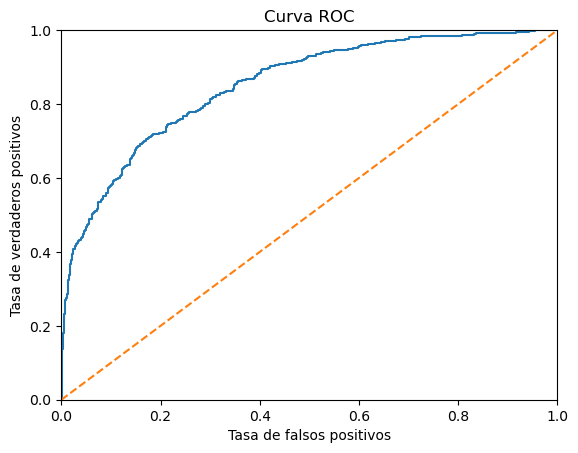

In [70]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

In [71]:
auc_roc = roc_auc_score(target_test,probabilities_one_test)
auc_roc

0.8510456686254905

Podemos comprobar que nuestro modelo funciona, posee un nivel de exactitud bueno de 0.851 aunque esta métrica no es demasiado fiable al ser este un caso con datos desbalanceados, mientras que por el lado del valor F1 es de una magnitud razonable aunque bajo a 0.582 con la base de datos de prueba. El valor de AUC-ROC nos dice que existe un 85% de probabilidades que los resultados arrojados por nuestro modelo sean correctos versus un modelo que arroje resultados aleatorios lo cual se encuentra dentro de un muy buen rango.

## 9. Conclusiones

Comenzamos el proyecto realizando una rápida exploración a la base de datos entregada por Beta Bank, encontrando valores ausentes en la columna "Tenure", estos debieron eran alrededor de un 10% de los datos y debían ser completados para poder correr de forma correcta los modelos predictivos. Independiente de lo anterior, no se encontraron problemas en ninguna de las otras columnas de la base de datos.

Continuamos con la segmentación de los datos, al solo poseer la base de datos entregada por Beta Bank se dividió la misma en tres segmentos para poder realizar el entrenamiento, validación y prueba del modelo.

Posteriormente procedimos a probar un modelo sin mayores ajustes, con este logramos comprobar que la base de datos posee un fuerte desequilibrio de clases que debería ser abordado más adelante.

Damos paso a la elección y mejoramiento del modelo, se realizaron pruebas sobre tres algoritmos de aprendizaje distintos, árbol de decisión, bosque aleatorio y regresión logística, buscando obtener el mejor valor f1 posible ajustando sus hiperparámetros. De las pruebas anteriormente realizadas los mejores modelos fueron uno basado en el arbol de decisión seguido del bosque aleatorio por una muy baja diferencia, en función a esto se procedió a resolver el desequilibrio de clases utilizando el hiperparámetro class_weight, el método de submuestreo y el método de sobremuestreo para elevar el valor F1 lo máximo posible por sobre lo requerido en el proyecto. Así se llegó a obtener dos modelos basados en el bosque aleatorio, uno utilizando el submuestreo y otro con el hiperparámetro class_weight, que poseen el valor F1 más alto y a su vez tienen una infima diferencia en este valor.

Finalmente se procedió a probar ambos modelos con el segmento de datos de prueba, obteniendo el mejor resultado con el hiperparámetro class_weight, con lo cual el modelo según el parámetro AUC-ROC tiene un 85% de probabilidades de predecir si un cliente dejara el servicio del banco versus decidirlo aleatoriamente, al comparar el valor final obtenido de AUC-ROC versus el valor F1 podemos notar que el modelo tiene una buena probabilidad de distinguir entre clases positivas y negativas pero que al ponderar la precisión y sensibilidad del mismo esta disminuye a un 58%.